# Yahoo Data

In [4]:
#!pip install pandas_datareader

In [3]:
import matplotlib.pyplot as plt 
from pandas_datareader import data
import os
import scipy.io as sio
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Visualize

In [5]:
df = data.get_data_yahoo('BTC-EUR')
df.index.names = ['Date']
df = df.sort_values('Date')
#df.insert(0, 'Date', df.index)
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

#print(df.dtypes)
df.head()

Date         High          Low         Open        Close  \
0 2019-09-17  9316.917969  9240.340820  9253.401367  9246.486328   
1 2019-09-18  9319.454102  8917.574219  9248.524414  9292.973633   
2 2019-09-19  9334.069336  9194.604492  9292.886719  9239.483398   
3 2019-09-20  9245.341797  9075.292969  9241.304688  9092.541992   
4 2019-09-21  9142.628906  9004.768555  9096.534180  9138.951172   

         Volume    Adj Close  
0  1.466026e+10  9246.486328  
1  1.804724e+10  9292.973633  
2  1.337076e+10  9239.483398  
3  1.218296e+10  9092.541992  
4  1.197878e+10  9138.951172

In [6]:
df.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [7]:
# columns=['High','Low', 'Open', 'Close', 'Volume', 'Adj Close']#, 


# for column_name in columns:
#     fig, ax = plt.subplots(figsize=(20, 8))
#     plt.plot(df['Date'],df[column_name],marker="+",label= column_name)
#     #plt.xticks(np.arange(9,13,step=1))  # Set text labels.
#     plt.legend(loc='center left', bbox_to_anchor=(1, 1))
#     plt.xlabel("Dates",fontsize=15)
#     #plt.ylim([0, 1])
#     plt.ylabel("Price",fontsize=15)
#     plt.title(column_name + " Price",fontsize=15)
#     plt.grid()
#     plt.show()                             

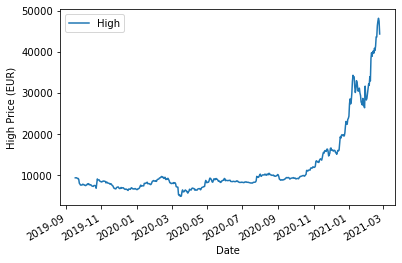

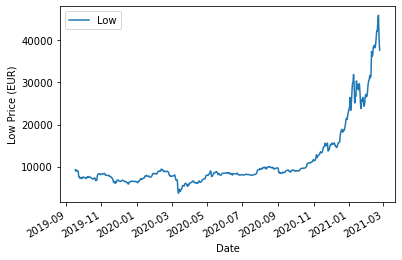

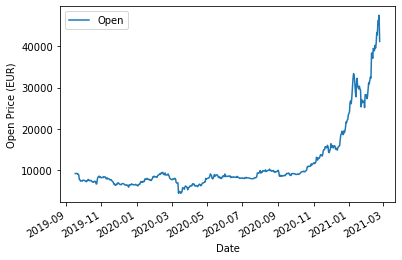

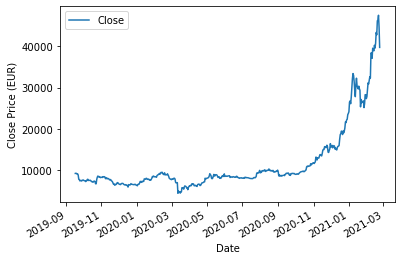

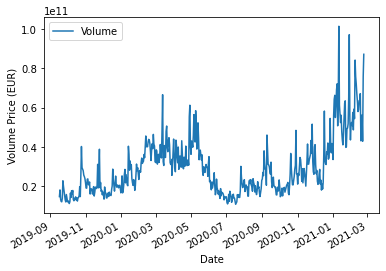

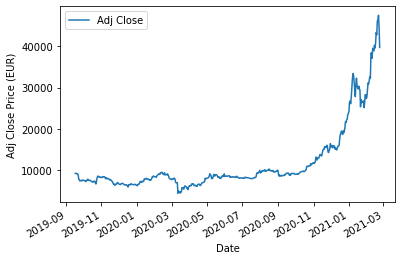

In [8]:
columns=['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']
for column_name in columns:
    ax = df.plot(x='Date', y=column_name);
    ax.set_xlabel("Date")
    ax.set_ylabel(column_name+ " Price (EUR)")

# Predict Future - Close Price

## 1-Normalize Data

Text(0, 0.5, 'Close Price (EUR)')

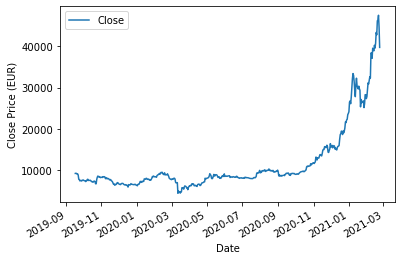

In [9]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (EUR)")

In [10]:
scaler = MinMaxScaler()

# We select the bitcoin closing price as our target variable to predict.
close_price = df.Close.values.reshape(-1, 1)  # -1 means unknown rows

scaled_close = scaler.fit_transform(close_price) #To center the data (make it have zero mean and unit standard error), you subtract the mean and then divide the result by the standard deviation.

#HANDLE MISSING VALUES  - Remove missing values if not a number             
scaled_close = scaled_close[~np.isnan(scaled_close)] #isnan-is not a number
print(scaled_close.shape)
scaled_close = scaled_close.reshape(-1, 1)

(521,)


Text(0, 0.5, 'Close Price (EUR)')

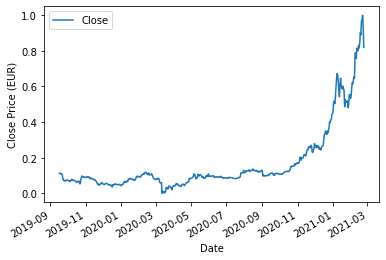

In [11]:
df['Close'] = scaled_close
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (EUR)")

## 2-Preprocessing

In [12]:
def window_data(data, window_size):
    """ window_size represents how many data points we are going to use to predict the next datapoint in the sequence. 
       ( e.g. window_size=50 we are going to use the previous 50 days to predict the bitcoin price for today)."""
    
    d = []
    for index in range(len(data) - window_size):
        
        d.append(data[index: index + window_size])#list 

    print("shape in window",np.shape(d)) #(3101, 100, 1)

    return np.array(d)

def preprocess(data_raw, window_size, train_split):

    data = window_data(data_raw, window_size)
    
    num_train = int(train_split * data.shape[0])
    print(data.shape[0])
    print("train data:", num_train)

    x_train = data[:num_train, :-1, :] # :-1 means begining from last(-1) exclusing last point
    
    y_train = data[:num_train, -1, :] # -1 means  last point

    x_test = data[num_train:, :-1, :] # :-1 means begining to last(-1) exclusing last point

    y_test = data[num_train:, -1, :] # -1 means last point
    return x_train, y_train, x_test, y_test

In [13]:
window_size = 100

x_train, y_train, x_test, y_test = preprocess(scaled_close, window_size, train_split = 0.80)
x_train.shape, x_test.shape

shape in window (421, 100, 1)
421
train data: 336


((336, 99, 1), (85, 99, 1))

## 3-Build The Model

In [14]:
model = tf.keras.Sequential()
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(window_size-1, return_sequences=True))    
#Fast LSTM implementation backed by cuDNN.    #cuDNN-NVIDIA CUDA® Deep Neural Network library        
#return_sequences: Boolean. Whether to return the last output. in the output sequence, or the full sequence.
model.add(tf.compat.v1.keras.layers.Dropout(0.2)) # to avoid overfitting
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(window_size-1, return_sequences=True))
model.add(tf.compat.v1.keras.layers.Dropout(0.2))
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(window_size-1))
model.add(tf.compat.v1.keras.layers.Dense(units=1)) #units: Integer or Long, dimensionality of the output space.
model.add(tf.compat.v1.keras.layers.Activation('linear'))


In [15]:
#Compile the model
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [16]:
#Train the model
batch_size = 64

history = model.fit(
    x_train, 
    y_train, 
    epochs=20, #a number of epochs means how many times you go through your training set.
    batch_size=batch_size
)

Epoch 1/20
6/6 [==============================] - 4s 673ms/step - loss: 0.0046
Epoch 2/20
6/6 [==============================] - 0s 17ms/step - loss: 0.0021
Epoch 3/20
6/6 [==============================] - 0s 20ms/step - loss: 0.0015
Epoch 4/20
6/6 [==============================] - 0s 19ms/step - loss: 9.8852e-04
Epoch 5/20
6/6 [==============================] - 0s 17ms/step - loss: 6.1416e-04
Epoch 6/20
6/6 [==============================] - 0s 17ms/step - loss: 4.1481e-04
Epoch 7/20
6/6 [==============================] - 0s 20ms/step - loss: 4.0170e-04
Epoch 8/20
6/6 [==============================] - 0s 20ms/step - loss: 3.2486e-04
Epoch 9/20
6/6 [==============================] - 0s 20ms/step - loss: 3.4195e-04
Epoch 10/20
6/6 [==============================] - 0s 19ms/step - loss: 3.0117e-04
Epoch 11/20
6/6 [==============================] - 0s 19ms/step - loss: 3.3864e-04
Epoch 12/20
6/6 [==============================] - 0s 19ms/step - loss: 3.1518e-04
Epoch 13/20
6/6 [=======

# Plot training & validation loss values

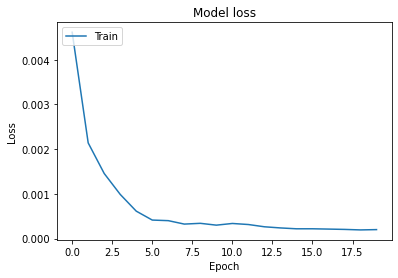

In [17]:
plt.plot(history.history['loss'])
#print(history.__dict__) 
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Evaluate Model

In [18]:
model.evaluate(x_test, y_test)

3/3 [==============================] - 4s 1s/step - loss: 0.0091


0.009125137701630592

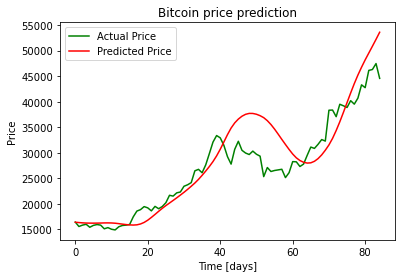

In [19]:
y_hat = model.predict(x_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();